# Medicare Fraud - Base Models

Mustapha Mbengue, Peyton Nash, Bradley Stoller, Kyler Rosen

3/9/25

Purpose: Specifies, trains and evaluates base models to classify cases of medicare fraud.

1. **Logistic Regression**
Pretty solid but not amazing—accuracy around 81%, and an F1 score of ~73% after tuning.
It’s fast and simple but struggles a bit with recall (69%), meaning it's missing some positive cases.

_______________________

2. **Random Forest**
Accuracy at 94.7%, and a strong F1 score of 92.5%.
Great balance between precision and recall, catching 86% of positive cases.
A really reliable option, especially after tuning.

___

3. **XGBoost**
The best performer Accuracy at 97.5%, with an  F1 score of 96.7%.
Near-perfect precision (99.8%) and a strong recall (93.7%).
Definitely the most powerful but might take longer to train.

___

4. **Naïve Bayes**
Meh. Accuracy at 80%, and an F1 score of ~70%, similar to Logistic Regression.
Works fast but not the best choice 
___
5. **Bernoulli Naïve Bayes**
 not good. Accuracy at 62.8%, and F1 at 19%—this one's not making the cut.



___

1. **Random Forest**

True Negatives (TN): 68,889 → Correctly classified negatives

False Positives (FP): 352 → Very few misclassified negatives

False Negatives (FN): 7,301 → Some missed positives

True Positives (TP): 35,434 → Strong positive classification




2. **Logistic Regression**

TN: 61,020

FP: 8,221 → Too many false positives

FN: 12,979 → High false negatives

TP: 29,756



3. **XGBoost (Best Performer)**

TN: 69,184

FP: 57 → Almost no false positives!

FN: 2,701 → Very few false negatives

TP: 40,034




4. **Gaussian Naïve Bayes**

TN: 63,475

FP: 5,766 → More false positives

FN: 16,501 → Too many missed positives

TP: 26,234



___


**Ensemble Model**

Overall Accuracy: 94.7% – solid and reliable.

Precision: 99.7% – almost no false positives.

Recall: 86.3% – catches most of the positive cases.

F1 Score: 92.6% – great balance between precision and recall.

Balanced Accuracy: 93.1% – good even with class imbalances.

ROC AUC: 98.8% – excellent at distinguishing between classes.

Additional metrics like Cohen’s Kappa (0.88) and MCC (0.89) show strong agreement between predictions and actual labels. Log Loss (0.2078) is low, meaning the model is well-calibrated.



### Setup

In [27]:
import pandas as pd
import numpy as np

# Function to pre-process this data
from data_preprocessing import process_data

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef, log_loss, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

import matplotlib.pyplot as plt

In [ ]:
# Handle warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Apply data processing script
df = process_data()

# Check DataFrame head
df.head()

Starting data preprocessing...
Merging raw data...
Merged raw data. Time elapsed: 10.57s
Correcting codes...
Corrected codes. Time elapsed: 58.67s
Loading the dataframe...
Loaded the dataframe. Time elapsed: 65.15s
Starting feature engineering...
Adding datetime features...
Added datetime features. Time elapsed: 16.05s
Discretizing age...
Discretized age. Time elapsed: 16.06s
Filling in missing values...
Filled in missing values. Time elapsed: 17.77s
Transforming skewed distributions...
Transformed skewed distributions. Time elapsed: 17.78s
Encoding categorical columns...
Encoded categorical columns. Time elapsed: 21.01s
Dropping unnecessary columns...
Dropped unnecessary columns. Time elapsed: 21.10s
Feature engineering complete!


,Provider,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,TotalClaims,Gender,Race,RenalDiseaseIndicator,State,...,NumProcedures,HospitalStayDays,ClaimDuration,DaysBeforeAdmission,ClaimStartMonth,ClaimStartWeekday,ClaimStartYear,DaysSinceLastClaim,AgeAtClaim,AgeGroup
0,3928,53275,0,0,3022,60,1,1,0,39,...,6,6.0,6,0.0,4,6,2009,0.0,66,2
1,3923,4951,2133,0,2298,60,1,1,0,39,...,6,2.0,2,0.0,8,0,2009,141.0,66,2
2,4034,40843,0,5202,851,14,1,1,0,39,...,6,3.0,3,0.0,9,3,2009,17.0,66,2
3,1125,39020,23576,14718,1602,22,2,2,0,1,...,6,8.0,8,0.0,2,5,2009,0.0,95,3
4,1125,39020,23576,14718,1602,22,2,2,0,1,...,6,8.0,8,0.0,2,5,2009,0.0,95,3


In [17]:
# Check meta data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559877 entries, 0 to 559876
Data columns (total 57 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Provider                         559877 non-null  int64  
 1   AttendingPhysician               559877 non-null  int64  
 2   OperatingPhysician               559877 non-null  int64  
 3   OtherPhysician                   559877 non-null  int64  
 4   ClmAdmitDiagnosisCode            559877 non-null  int64  
 5   TotalClaims                      559877 non-null  int64  
 6   Gender                           559877 non-null  int64  
 7   Race                             559877 non-null  int64  
 8   RenalDiseaseIndicator            559877 non-null  int64  
 9   State                            559877 non-null  int64  
 10  County                           559877 non-null  int64  
 11  NoOfMonths_PartACov              559877 non-null  int64  
 12  No

In [ ]:
# Identify target column
target_column = 'PotentialFraud'

# Train and test split
X = df.drop(columns=[target_column])
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Create functions to specify, train, tune and evaluate models

In [8]:
# Create a function to train classification models without tuning
def train_classification_models(X_train, X_test, y_train, y_test):
    
    # Speficy the models to be trained and test
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "nb_model": GaussianNB(),
        'Bernoulli': BernoulliNB(alpha=1.0, binarize=0.0),
        # "SVM": SVC(probability=True)  # Uncomment to include SVM
    }

    # Create a dictionary to store results
    results = {}

    # Train the models
    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Calculate cross validation scores for each model
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

        # Fit the models
        model.fit(X_train, y_train)

        # Predict the test set
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Create dictionary of metrics
        metrics = {
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None,
            "Cross-Validation F1 (Mean)": np.mean(cv_scores)
        }

        # Create a dictionary of the model and metrics
        results[name] = {"model": model, "metrics": metrics}

        # Print the metrics
        print(f"{name} Model Performance:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    return results

In [11]:
# Create a function to tune the models
def train_optimized_classification_models(X_train, X_test, y_train, y_test, n_iter=10):
    # Define parameters for testing
    param_distributions = {
        "Logistic Regression": {
            "model": LogisticRegression(),
            "params": {"C": np.logspace(-3, 3, 10), "penalty": ["l1", "l2"], "solver": ["liblinear"]}
        },
        "Random Forest": {
            "model": RandomForestClassifier(random_state=42),
            "params": {"n_estimators": np.arange(50, 300, 50), "max_depth": [5, 10, None], "min_samples_split": [2, 5, 10]}
        },
        "XGBoost": {
            "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            "params": {"n_estimators": np.arange(50, 300, 50), "learning_rate": np.linspace(0.01, 0.2, 5), "max_depth": [3, 5, 10]}
        },
        "Gaussian Naïve Bayes": {
            "model": GaussianNB(),
            "params": {"var_smoothing": np.logspace(-9, -6, 10)}
        },
        # "SVM": {
        #     "model": SVC(probability=True),
        #     "params": {"C": np.logspace(-3, 3, 10), "kernel": ["linear", "rbf", "poly"]}
        # }
    }

    # Create a dictionary to store model results
    best_models = {}

    # Train, fit and predict the models
    for name, config in param_distributions.items():
        print(f"\nTraining and tuning {name}...")

        # Exclude Gaussian Naive Bayes from tuning
        if name == "Gaussian Naïve Bayes":
            model = config["model"]
            model.fit(X_train, y_train)
            best_model = model
            best_params = None  
        else:
            # Complete random search cross validation
            random_search = RandomizedSearchCV(
                config["model"], config["params"], n_iter=n_iter, cv=5, scoring="f1", n_jobs=-1, random_state=42
            )

            # Fit the best performing model
            random_search.fit(X_train, y_train)

            # Store the estimator and parameters of the best performing model
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_

        # Calculate the cross validation score
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')

        # Predict the test set
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

        # Create a dictionary of metrics
        metrics = {
            "Best Params": best_params,
            "Cross-Validation F1 (Mean)": np.mean(cv_scores),
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
        }

        # Create a dictionary of models and metrics
        best_models[name] = {"model": best_model, "metrics": metrics}

        # Print the metrics
        print(f"\n{name} Best Parameters: {best_params}")
        for metric, value in metrics.items():
            if metric != "Best Params":
                print(f"{metric}: {value:.4f}")

    return best_models

In [12]:
# Create a function to construct a confusion matrix
def analyze_model_errors(model, X_test, y_test):
    """
    Analyze errors using a confusion matrix.
    """
    y_pred = model.predict(X_test)

    # Create a confusion matrix    
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
    disp.plot(cmap="Blues")
    
    print("\nConfusion Matrix:")
    print(cm)


In [30]:
# Create a function to train and predict ensemble model metrics
def train_voting_ensemble(models, X_train, X_test, y_train, y_test):
    voting_clf = VotingClassifier(
        estimators=[
            ("Random Forest", models["Random Forest"]["model"]),
            ("Logistic Regression", models["Logistic Regression"]["model"]),
            ("XGBoost", models["XGBoost"]["model"])
        ],
        voting="soft"  # Soft voting considers probability predictions
    )

    voting_clf.fit(X_train, y_train)
    return voting_clf

In [14]:
# Create a function to evaluate the ensemble model
def evaluate_final_model(model, X_train, y_train, X_test, y_test, cv=5):
    # Predict the values for each model
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate cross-validation scores    
    cv_f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    cross_val_f1_mean = np.mean(cv_f1_scores)

    # Create metrics dictionary
    metrics = {
        "Cross-Validation F1 (Mean)": cross_val_f1_mean,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
        "Cohen's Kappa": cohen_kappa_score(y_test, y_pred),
        "Matthews Corr Coeff (MCC)": matthews_corrcoef(y_test, y_pred),
        "Log Loss": log_loss(y_test, y_prob) if y_prob is not None else None,
        "ROC AUC Score": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

    # Print classification report
    print("\nFinal Model Performance on Test Set:")
    print(classification_report(y_test, y_pred))

    # Print metrics
    for metric, value in metrics.items():
        if value is not None:
            print(f"{metric}: {value:.4f}")

    return metrics


### Train, Predict and Evaluate Models

In [15]:
# Train and predict basic classification models
results = train_classification_models(X_train, X_test, y_train, y_test)


Training Logistic Regression...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Logistic Regression Model Performance:
Accuracy: 0.7999
Precision: 0.8100
Recall: 0.6216
F1 Score: 0.7034
ROC AUC: 0.8394
Cross-Validation F1 (Mean): 0.6997

Training Random Forest...
Random Forest Model Performance:
Accuracy: 0.9311
Precision: 0.9895
Recall: 0.8281
F1 Score: 0.9017
ROC AUC: 0.9835
Cross-Validation F1 (Mean): 0.8968

Training XGBoost...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:19:57] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:19:58] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:19:59] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning

XGBoost Model Performance:
Accuracy: 0.9706
Precision: 0.9927
Recall: 0.9299
F1 Score: 0.9602
ROC AUC: 0.9955
Cross-Validation F1 (Mean): 0.9605

Training nb_model...
nb_model Model Performance:
Accuracy: 0.8011
Precision: 0.8198
Recall: 0.6139
F1 Score: 0.7021
ROC AUC: 0.8043
Cross-Validation F1 (Mean): 0.6996

Training Bernoulli...
Bernoulli Model Performance:
Accuracy: 0.6283
Precision: 0.5648
Recall: 0.1130
F1 Score: 0.1883
ROC AUC: 0.5317
Cross-Validation F1 (Mean): 0.1909


In [16]:
# Tune, train and predict optimized models
best_models = train_optimized_classification_models(X_train, X_test, y_train, y_test)


Training and tuning Logistic Regression...

Logistic Regression Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1000.0}
Cross-Validation F1 (Mean): 0.7362
Accuracy: 0.8107
Precision: 0.7835
Recall: 0.6963
F1 Score: 0.7374
ROC AUC: 0.8630

Training and tuning Random Forest...


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Random Forest Best Parameters: {'n_estimators': 250, 'min_samples_split': 5, 'max_depth': None}
Cross-Validation F1 (Mean): 0.8966
Accuracy: 0.9328
Precision: 0.9897
Recall: 0.8326
F1 Score: 0.9044
ROC AUC: 0.9846

Training and tuning XGBoost...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:55:13] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:55:13] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:55:13] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning


XGBoost Best Parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.0575}
Cross-Validation F1 (Mean): 0.9664
Accuracy: 0.9754
Precision: 0.9986
Recall: 0.9368
F1 Score: 0.9667
ROC AUC: 0.9982

Training and tuning Gaussian Naïve Bayes...

Gaussian Naïve Bayes Best Parameters: None
Cross-Validation F1 (Mean): 0.6996
Accuracy: 0.8011
Precision: 0.8198
Recall: 0.6139
F1 Score: 0.7021
ROC AUC: 0.8043


Random Forest


Confusion Matrix:
[[68871   370]
 [ 7155 35580]]


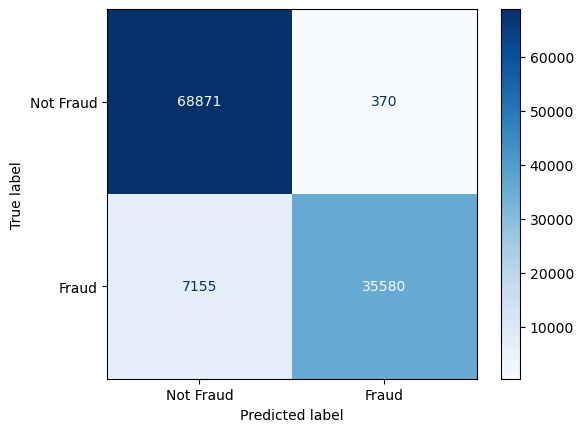

In [19]:

print("Random Forest\n")
analyze_model_errors(best_models["Random Forest"]["model"], X_test, y_test)

Logistic Regression


Confusion Matrix:
[[61019  8222]
 [12977 29758]]


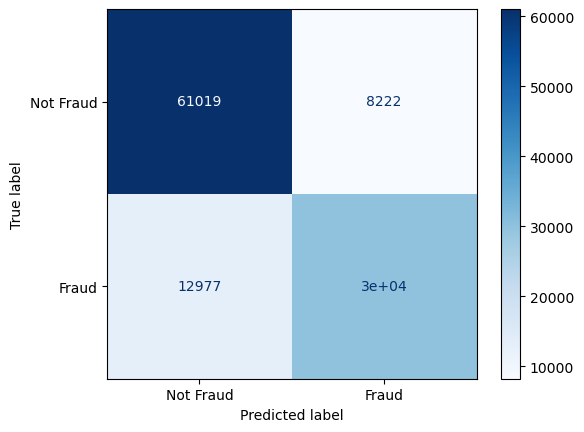

In [20]:
print("Logistic Regression\n")

analyze_model_errors(best_models["Logistic Regression"]["model"], X_test, y_test)

XGBoost 


Confusion Matrix:
[[69184    57]
 [ 2701 40034]]


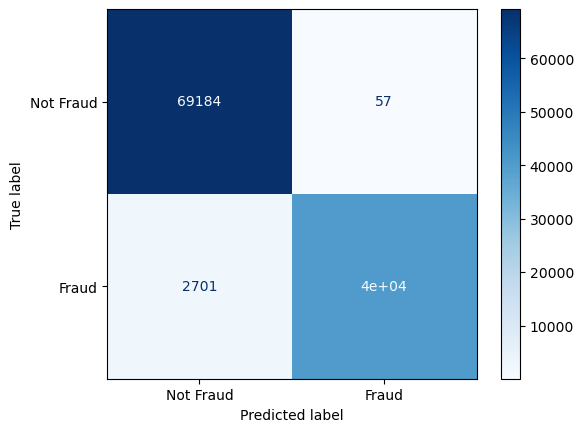

In [21]:
print("XGBoost \n")

analyze_model_errors(best_models["XGBoost"]["model"], X_test, y_test)

Gaussian Naïve Bayes


Confusion Matrix:
[[63475  5766]
 [16501 26234]]


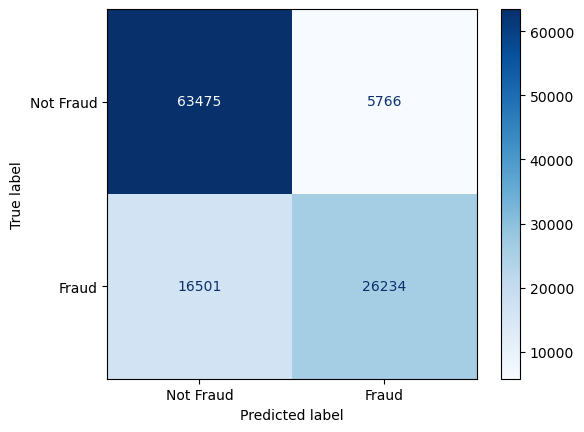

In [22]:
print("Gaussian Naïve Bayes\n")
analyze_model_errors(best_models["Gaussian Naïve Bayes"]["model"], X_test, y_test)

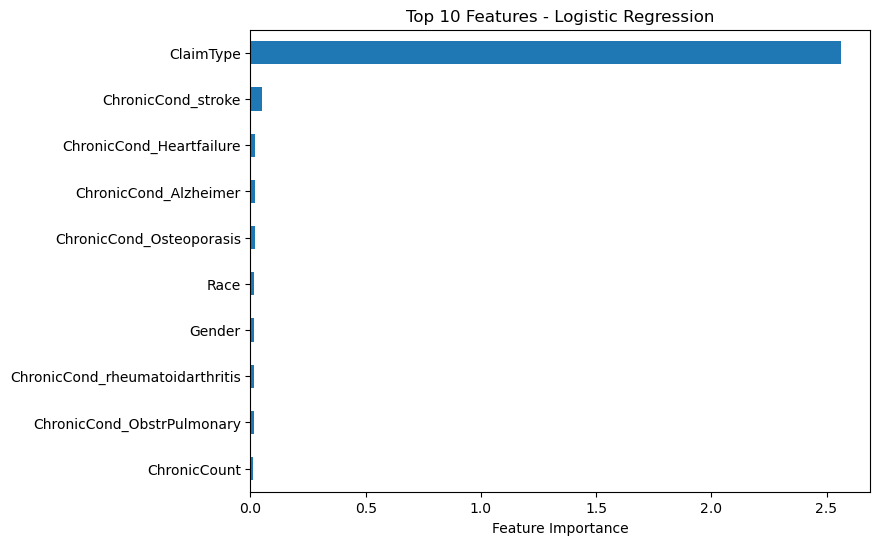

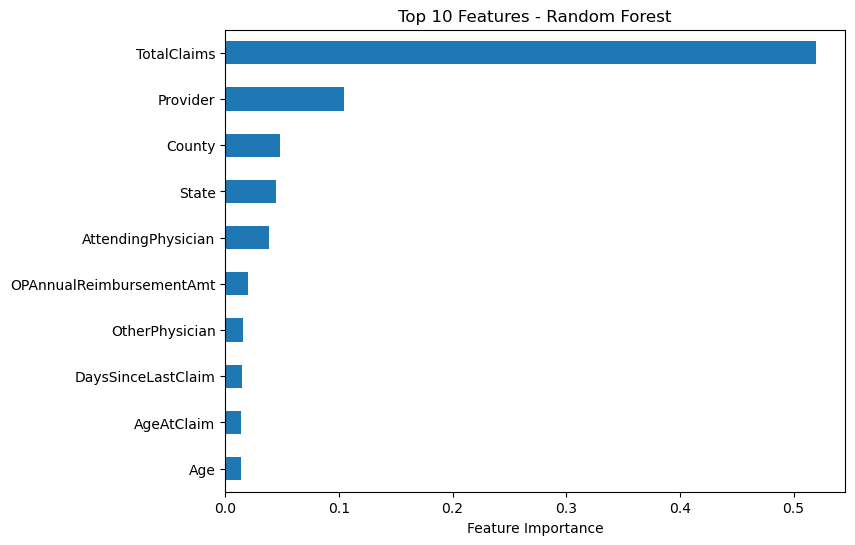

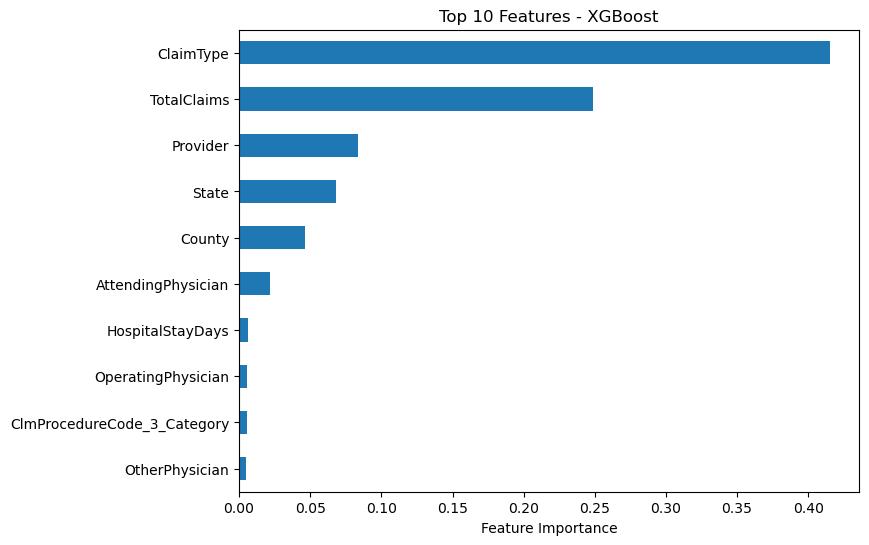

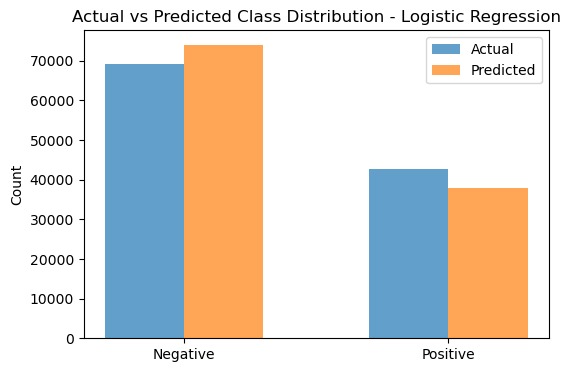

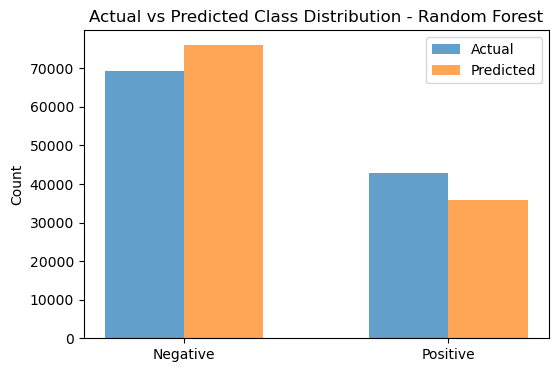

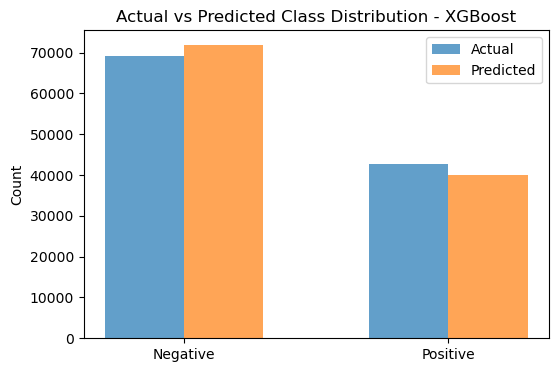

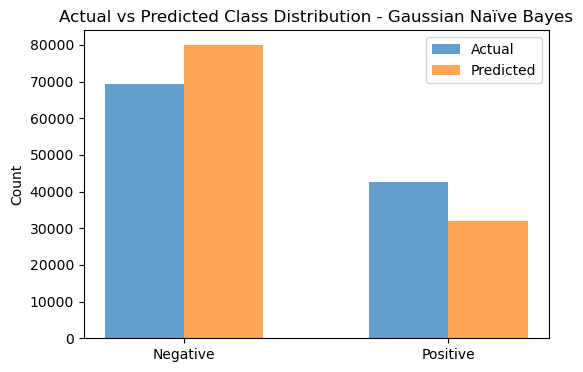

In [23]:
# Calculate predicted values for each model
model_predictions = {}
for model_name, model_info in best_models.items():
    model = model_info["model"]
    y_pred = model.predict(X_test)
    model_predictions[model_name] = y_pred

# Calculate feature importance
feature_importances = {}
for model_name, model_info in best_models.items():
    model = model_info["model"]
    
    if hasattr(model, "feature_importances_"):  
        importance = model.feature_importances_
    elif hasattr(model, "coef_"):  
        importance = np.abs(model.coef_[0])
    else:
        continue  

    feature_importances[model_name] = pd.Series(importance, index=X_test.columns).sort_values(ascending=False)

# Create feature importance plots
for model_name, importance_series in feature_importances.items():
    plt.figure(figsize=(8, 6))
    importance_series[:10].plot(kind="barh", title=f"Top 10 Features - {model_name}")
    plt.xlabel("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

# Create class distribution plots
for model_name, y_pred in model_predictions.items():
    plt.figure(figsize=(6, 4))
    actual_counts = pd.Series(y_test).value_counts().sort_index()
    predicted_counts = pd.Series(y_pred).value_counts().sort_index()

    width = 0.3  
    x = np.arange(len(actual_counts))  

    plt.bar(x - width/2, actual_counts, width=width, label="Actual", alpha=0.7)
    plt.bar(x + width/2, predicted_counts, width=width, label="Predicted", alpha=0.7)

    plt.xticks(ticks=x, labels=["Negative", "Positive"])
    plt.ylabel("Count")
    plt.title(f"Actual vs Predicted Class Distribution - {model_name}")
    plt.legend()
    plt.show()


In [31]:
# Estimate the voting model classifier
voting_model = train_voting_ensemble(best_models, X_train, X_test, y_train, y_test)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:08:08] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [32]:
# Calculate metrics for the voting model classifier
final_metrics = evaluate_final_model(voting_model, X_train, y_train, X_test, y_test)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:11:46] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:14:09] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:16:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning


Final Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     69241
           1       1.00      0.87      0.93     42735

    accuracy                           0.95    111976
   macro avg       0.96      0.93      0.94    111976
weighted avg       0.95      0.95      0.95    111976

Cross-Validation F1 (Mean): 0.9195
Accuracy: 0.9476
Precision: 0.9973
Recall: 0.8651
F1 Score: 0.9265
Balanced Accuracy: 0.9318
Cohen's Kappa: 0.8862
Matthews Corr Coeff (MCC): 0.8916
Log Loss: 0.2067
ROC AUC Score: 0.9882
